# Projet : Classification d'aliments pour le tri automatique TP1 et TP2

# TP1


Kevin GUILBAUT, Aslam SABIR

## Imports des bibliothèques et de la base de données.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fruits' dataset.
Path to dataset files: /kaggle/input/fruits


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
import optuna
import shutil
from tqdm import tqdm
import cv2
import random
import faiss
import torch
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow import keras
import keras
from transformers import CLIPProcessor, CLIPModel
import json

BASE_DIR = "data/fruits-360_100x100/fruits-360"

train_path = os.path.join(BASE_DIR, "Training")
test_path = os.path.join(BASE_DIR, "Test")

print(f"Dossier 'Training' : {os.path.exists(train_path)}")
print(f"Dossier 'Test' : {os.path.exists(test_path)}")


c:\Users\aslam\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dossier 'Training' : True
Dossier 'Test' : True


## Paramètres globaux

In [17]:
BATCH_SIZE = 32
SEED = 67
NB_TOP_CLASSES=75
BATCH_SIZE = 32
IMAGE_SIZE = (100, 100)
EPOCHS = 15

## Analyse Exploratoire

### Analyse de la distribution des classes

In [5]:
# Lister les classes (qui sont les noms des sous-dossiers)
class_names = sorted(os.listdir(train_path))
print(f"Nombre total de classes : {len(class_names)}")
print("\nExemple de noms de classes :")
print(class_names[10:17])

# Compter les images par classe
distribution = {}
for fruit_class in class_names:
    class_dir = os.path.join(train_path, fruit_class)
    # Compter le nombre de fichiers .jpg ou .png
    count = len([f for f in os.listdir(class_dir)
                 if f.endswith(('.jpg', '.png', '.jpeg'))])
    distribution[fruit_class] = count

# Convertir en DataFrame Pandas pour une analyse facile
df_distribution = pd.DataFrame(list(distribution.items()), columns=['Classe', 'Nombre d\'images'])

print(df_distribution.head())

print("\nStatistiques sur la distribution :")
print(df_distribution['Nombre d\'images'].describe())

Nombre total de classes : 225

Exemple de noms de classes :
['Apple 7', 'Apple 8', 'Apple 9', 'Apple Braeburn 1', 'Apple Core 1', 'Apple Crimson Snow 1', 'Apple Golden 1']
     Classe  Nombre d'images
0  Apple 10              699
1  Apple 11              430
2  Apple 12              466
3  Apple 13              699
4  Apple 14              466

Statistiques sur la distribution :
count    225.000000
mean     522.560000
std      162.679701
min      144.000000
25%      453.000000
50%      490.000000
75%      694.000000
max      984.000000
Name: Nombre d'images, dtype: float64


Nous remarquons que dans notre base de donnée, nous ne devons pas seulement prédire le fruit, mais la variété du fruit. Nous considérons donc chaque variété comme étant une classe, ce qui nous donne 225 classes.

### Visualisation d'échantillons aléatoires

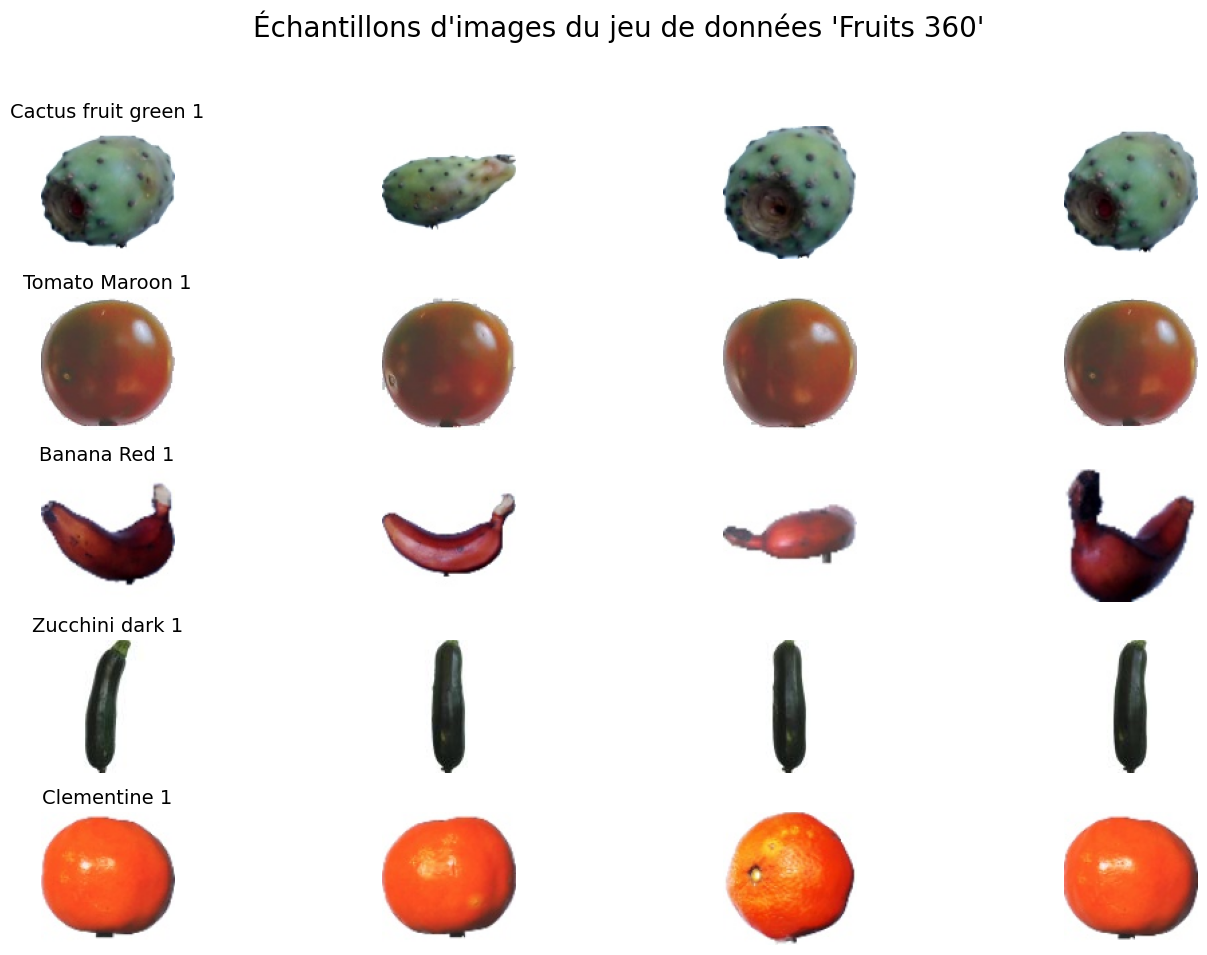

In [ ]:
num_classes_to_show = 5
num_images_per_class = 4

plt.figure(figsize=(15, 10))
# Prendre 5 classes au hasard
random_classes = np.random.choice(class_names, num_classes_to_show, replace=False)

for i, class_name in enumerate(random_classes):
    class_path = os.path.join(train_path, class_name)
    # Prendre 4 images au hasard
    all_image_files = os.listdir(class_path)

    if len(all_image_files) >= num_images_per_class:
        image_files = np.random.choice(all_image_files, num_images_per_class, replace=False)
    else:
        image_files = all_image_files
    for j, img_file in enumerate(image_files):
        img_path = os.path.join(class_path, img_file)

        # Lire l'image
        img = Image.open(img_path)

        ax = plt.subplot(num_classes_to_show, num_images_per_class, i * num_images_per_class + j + 1)
        plt.imshow(img)
        plt.axis('off')

        # Titre pour la première image
        if j == 0:
            plt.title(class_name, fontsize=14)

plt.suptitle("Échantillons d'images du jeu de données 'Fruits 360'", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Voici l'affichage aléatoire de 4 fruits provenant de 5 variétés différentes pour se faire une idée de ce que compose notre base de donnée.

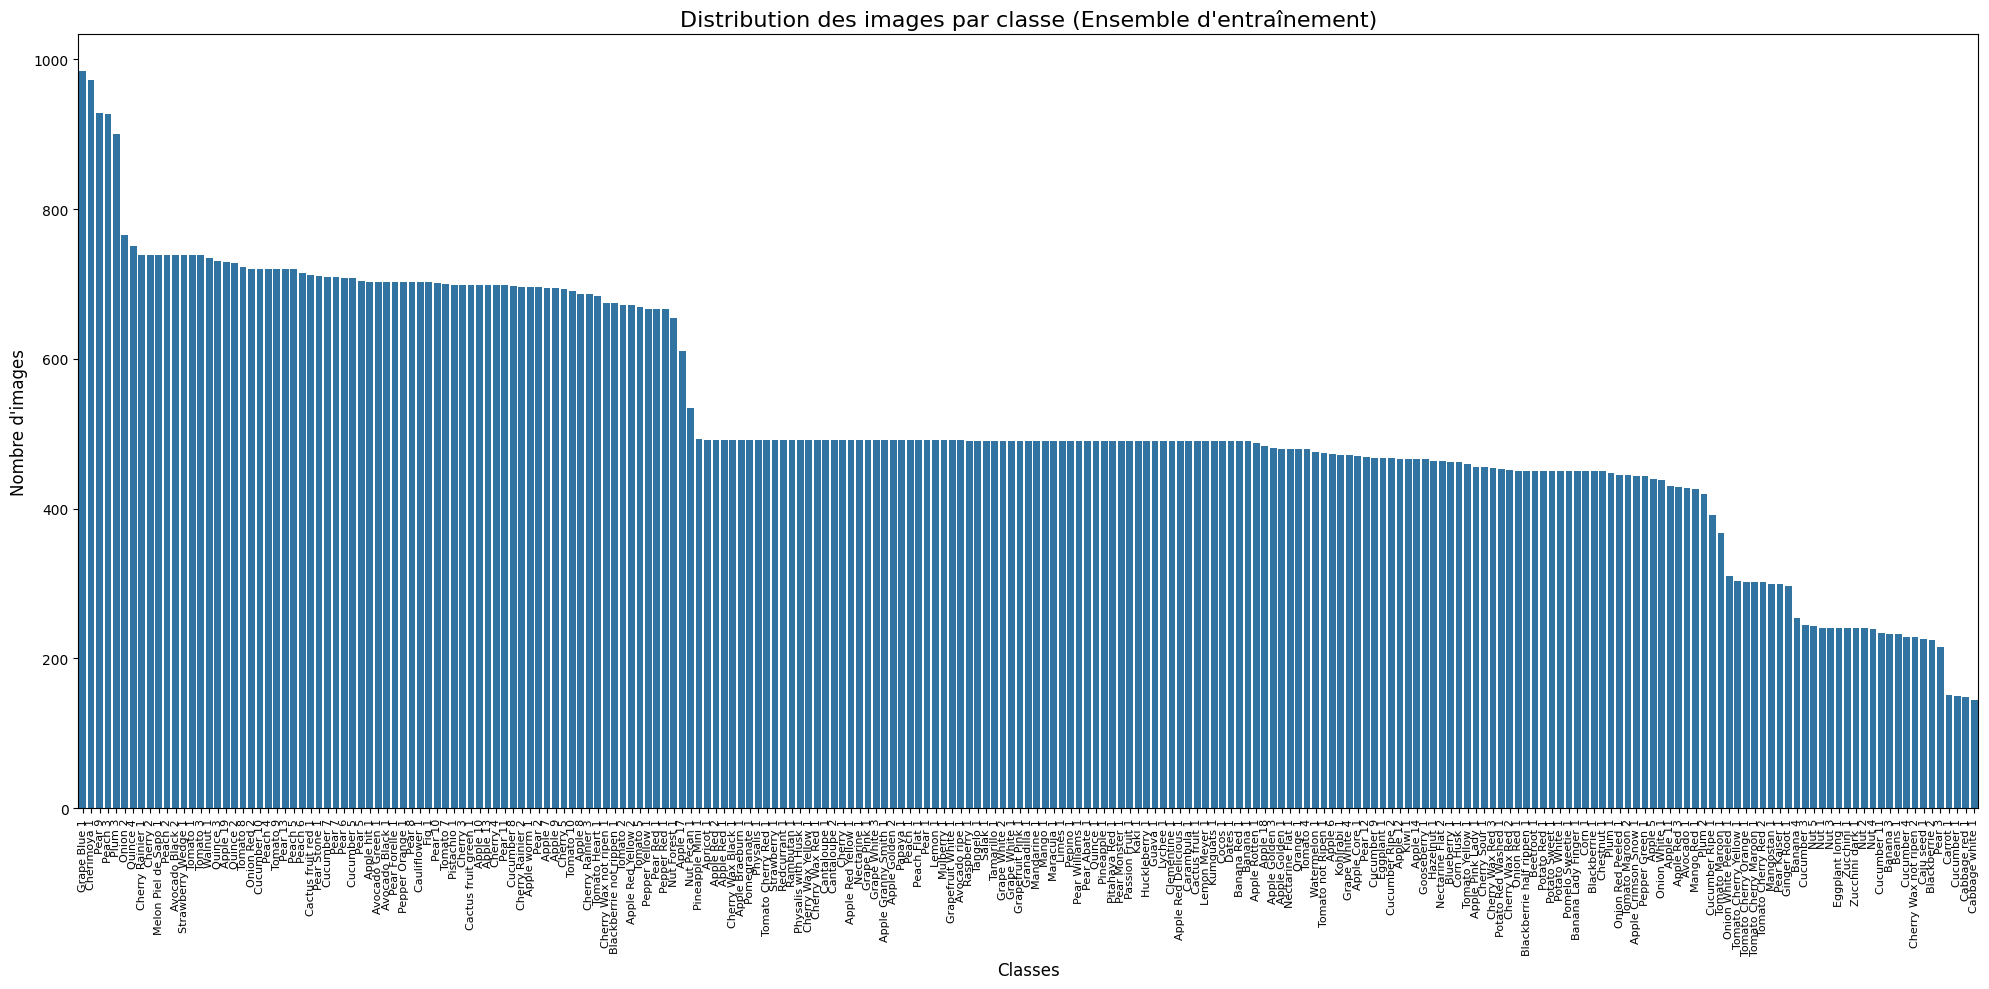

Classes avec le MOINS d'images :
              Classe  Nombre d'images
49   Cabbage white 1              144
48     Cabbage red 1              149
81        Cucumber 1              150
57          Carrot 1              151
157           Pear 3              215

Classes avec le PLUS d'images :
           Classe  Nombre d'images
99   Grape Blue 1              984
59    Cherimoya 1              972
162        Pear 9              928
146       Peach 3              927
183        Plum 3              900


In [8]:
plt.figure(figsize=(20, 10))

# Trier par ordre decroissant
df_sorted = df_distribution.sort_values(by='Nombre d\'images', ascending=False)

sns.barplot(data=df_sorted, x='Classe', y='Nombre d\'images')

plt.title('Distribution des images par classe (Ensemble d\'entraînement)', fontsize=16)
plt.ylabel('Nombre d\'images', fontsize=12)
plt.xlabel('Classes', fontsize=12)

plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

print("Classes avec le MOINS d'images :")
print(df_distribution.sort_values(by='Nombre d\'images', ascending=True).head())

print("\nClasses avec le PLUS d'images :")
print(df_distribution.sort_values(by='Nombre d\'images', ascending=False).head())

Nous remarquons ici que la distribution des classes est très déséquilibrée. En effet, la classe avec le plus d'images en a 984, contre 144 pour celle qui en a le moins, ce qui pourrait poser un problème pour les performances de notre futur modèle. De plus, nous avons énormément de données, ce qui peut fortement ralentir l'affinage de notre modèle. Pour cette raison, nous avons décidé de ne prendre que les 75 classes les plus représentées. Nous avons choisi 75 car après ce nombre, nous observons une grosse chute du nombre d'images disponibles pour les classes.

## Préparation et Prétraitement

### Normalisation

In [ ]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.squeeze(tf.cast(image, tf.float32), axis=-1) / 255.0, label

### Vérification dimension d'une image

In [ ]:
# Taille des images
sample_class = class_names[0]
sample_image_path = os.path.join(train_path, sample_class, os.listdir(os.path.join(train_path, sample_class))[10])
sample_image = Image.open(sample_image_path)
print(f"Taille d'une image exemple : {sample_image.size}")

Taille d'une image exemple : (100, 100)


In [ ]:
#  Garder les  classes principales
df_sorted = df_distribution.sort_values(by='Nombre d\'images', ascending=False)
TOP_CLASSES = df_sorted['Classe'].head(NB_TOP_CLASSES).tolist()

print(f"Les classes gardées sont : {TOP_CLASSES}")
print(f"Nombre de classes total : {len(TOP_CLASSES)}")



train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(100,100),
    batch_size=BATCH_SIZE,
    class_names=TOP_CLASSES

)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(100,100),
    batch_size=BATCH_SIZE,
    class_names=TOP_CLASSES

)



test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(100, 100),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_names=TOP_CLASSES
)

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]

print(f"Valeur minimale : {np.min(first_image)}")
print(f"Valeur maximale : {np.max(first_image)}")

print(train_ds)

Les 5 classes gardées sont : ['Grape Blue 1', 'Cucumber 6', 'Cherimoya 1', 'Pear 9', 'Peach 3', 'Plum 3', 'Onion 2', 'Quince 4', 'Cherry 2', 'Cherry Rainier 1', 'Melon Piel de Sapo 1', 'Peach 2', 'Avocado Black 2', 'Strawberry Wedge 1', 'Tomato 1', 'Tomato 3', 'Walnut 1', 'Quince 3', 'Apple 19', 'Quince 2', 'Tomato 8', 'Onion Red 2', 'Cucumber 10', 'Peach 4', 'Tomato 9', 'Pear 13', 'Peach 5', 'Peach 6', 'Cactus fruit red 1', 'Pear Stone 1', 'Cucumber 7', 'Pear 7', 'Pear 6', 'Cucumber 5', 'Pear 5', 'Apple hit 1', 'Cauliflower 1', 'Avocado Black 1', 'Pear Forelle 1', 'Pepper Orange 1', 'Pear 8', 'Avocado Green 1', 'Fig 1', 'Pear 10', 'Tomato 7', 'Pistachio 1', 'Cherry 3', 'Cactus fruit green 1', 'Apple 13', 'Apple 10', 'Cherry 4', 'Pear 11', 'Cucumber 8', 'Cherry Rainier 2', 'Apple worm 1', 'Pear 2', 'Apple 7', 'Apple 9', 'Cherry 5', 'Tomato 10', 'Apple 8', 'Cherry Rainier 3', 'Tomato Heart 1', 'Cherry Wax not ripen 1', 'Blackberrie not rippen 1', 'Tomato 2', 'Apple Red Yellow 2', 'Tomat

## Baseline CNN

Voici notre baseline, un CNN que nous avons construit manuellement. Nous avons volontairement opté pour une architecture simple avec très peu de couches, dans le but d'obtenir des courbes d'apprentissage significatives. Cela nous permet de démontrer que, même avec un modèle très peu profond, il reste performant, et de mieux illustrer l'efficacité et l'utilité de MobileNetV2.

In [ ]:
IMAGE_SIZE = (100,100)
NUM_CLASSES = len(TOP_CLASSES)
NB_EPOCHS=15

input_shape = IMAGE_SIZE + (3,)
LEARNING_RATE = 0.001

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 307328)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    19,669,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │         4,875 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,674,827 (75.05 MB)

 Trainable params: 19,674,827 (75.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_fit = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=NB_EPOCHS
)

Epoch 1/15
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 736s 545ms/step - accuracy: 0.0397 - loss: 4.7725 - val_accuracy: 0.4203 - val_loss: 2.1083
Epoch 2/15
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 682s 506ms/step - accuracy: 0.3538 - loss: 2.2254 - val_accuracy: 0.8457 - val_loss: 0.6412
Epoch 3/15
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 680s 504ms/step - accuracy: 0.5389 - loss: 1.4171 - val_accuracy: 0.9033 - val_loss: 0.3936
Epoch 4/15
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 693s 514ms/step - accuracy: 0.6095 - loss: 1.1917 - val_accuracy: 0.9266 - val_loss: 0.3281
Epoch 5/15
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 695s 515ms/step - accuracy: 0.6495 - loss: 1.0572 - val_accuracy: 0.9524 - val_loss: 0.2377
Epoch 6/15
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 740s 514ms/step - accuracy: 0.6829 - loss: 0.9600 - val_accuracy: 0.9609 - val_loss: 0.2206
Epoch 7/15
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 755s 524ms/step - accuracy: 0.6963 - loss: 0.9165 - val_accuracy: 0.9678 - val_loss: 0.1671
Epoch 8/15
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 719s 506ms/step - ac

In [ ]:
model.save('base_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Import de MobileNetV2

Pour obtenir de bons résultats avec notre MobileNetV2, nous avons choisi d’effectuer l’entraînement en deux étapes.

Dans un premier temps, nous gelons toutes les couches du modèle pré-entraîné (transfer learning) afin de n’entraîner que la tête de classification. Nous procédons alors à un premier fit sur nos ensembles d’entraînement et de validation.

Dans un second temps, nous dégelons uniquement les 30 dernières couches du modèle. Nous utilisons alors un faible learning rate pour éviter d’altérer les représentations pré-apprises pendant le pré-entraînement. Nous ré-entraînons ensuite le modèle : cela lui permet de s’adapter davantage à nos données spécifiques, tout en conservant les bénéfices du pré-entraînement.

In [ ]:
# Entraînement Fine-Tuning
FINE_TUNE_EPOCHS = 5
TOTAL_EPOCHS = NB_EPOCHS + FINE_TUNE_EPOCHS

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


base_model = tf.keras.applications.MobileNetV2(
    input_shape=(100, 100, 3),
    include_top=False,
    weights='imagenet'
)

# Geler toutes les couches du modèle
base_model.trainable = False

# Construction de la tête de classification
inputs = tf.keras.Input(shape=(100, 100, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_tl = tf.keras.Model(inputs, outputs)

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history_tl = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NB_EPOCHS-FINE_TUNE_EPOCHS,
    callbacks=[early_stop],
    verbose=1
)



# On dégèle tout d'abord le modèle
base_model.trainable = True

# On ne dégèle que les 30 dernières couches pour éviter de détruire les features pré-apprises
FINE_TUNE_AT = 30
for layer in base_model.layers[:-FINE_TUNE_AT]:
    layer.trainable = False

# Recompilation après modification du trainable
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history_fine = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NB_EPOCHS,
    initial_epoch=history_tl.epoch[-1] + 1,
    callbacks=[early_stop],
    verbose=1
)

In [ ]:
model_tl.save('model_tl.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Courbes des accuracy et loss de nos modèles

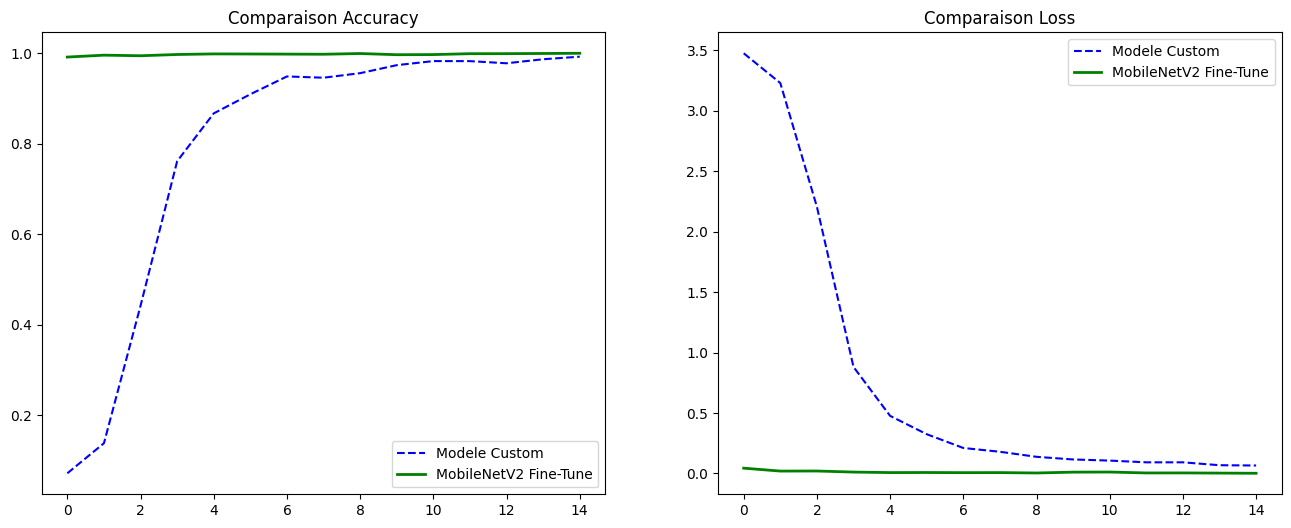

In [ ]:
# Extraction des historiques
acc_custom = model_fit.history['accuracy']
val_acc_custom = model_fit.history['val_accuracy']
loss_custom = model_fit.history['loss']
val_loss_custom = model_fit.history['val_loss']

acc_ft = history_tl.history['accuracy'] + history_fine.history['accuracy']
val_acc_ft = history_tl.history['val_accuracy'] + history_fine.history['val_accuracy']
loss_ft = history_tl.history['loss'] + history_fine.history['loss']
val_loss_ft = history_tl.history['val_loss'] + history_fine.history['val_loss']

# Graphiques
epochs_range_custom = range(len(acc_custom))
epochs_range_ft = range(len(acc_ft))

plt.figure(figsize=(16, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range_custom, val_acc_custom, '--', label='Modele Custom', color='blue')
plt.plot(epochs_range_ft, val_acc_ft, '-', label='MobileNetV2 Fine-Tune', color='green', linewidth=2)
plt.title('Comparaison Accuracy')
plt.legend(loc='lower right')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range_custom, val_loss_custom, '--', label='Modele Custom', color='blue')
plt.plot(epochs_range_ft, val_loss_ft, '-', label='MobileNetV2 Fine-Tune', color='green', linewidth=2)
plt.title('Comparaison Loss')
plt.legend(loc='upper right')

plt.show()

In [ ]:
class_names = TOP_CLASSES
y_true = np.concatenate([y for x, y in test_ds], axis=0)

predictions_prob_base = model.predict(test_ds)
y_pred_base = np.argmax(predictions_prob_base, axis=1)
predictions_prob = model_tl.predict(test_ds)
y_pred = np.argmax(predictions_prob, axis=1)

print(f"Accuracy base line: {accuracy_score(y_true, y_pred_base)}")
print(f"Accuracy MobileNetV2 Fine-Tune: {accuracy_score(y_true, y_pred)}")
print("\nClassification Report CNN:")
print(classification_report(y_true, y_pred_base, target_names=class_names))

print("\nClassification Report MobileNetV2 Fine-Tune:")
print(classification_report(y_true, y_pred, target_names=class_names))  


560/560 ━━━━━━━━━━━━━━━━━━━━ 67s 119ms/step
560/560 ━━━━━━━━━━━━━━━━━━━━ 149s 262ms/step
Accuracy base line: 0.9676590515556052
Accuracy MobileNetV2 Fine-Tune: 0.9881584092051612
                          precision    recall  f1-score   support

            Grape Blue 1       1.00      1.00      1.00       328
              Cucumber 6       0.95      1.00      0.97       325
             Cherimoya 1       1.00      1.00      1.00       320
                  Pear 9       1.00      1.00      1.00       308
                 Peach 3       1.00      1.00      1.00       306
                  Plum 3       1.00      1.00      1.00       304
                 Onion 2       0.88      0.99      0.93       255
                Quince 4       0.99      1.00      0.99       249
                Cherry 2       0.85      0.57      0.68       246
        Cherry Rainier 1       1.00      0.62      0.76       246
    Melon Piel de Sapo 1       1.00      0.89      0.94       246
                 Peach 2    

Le modèle baseline atteint une précision globale de 96,76 %, tandis que le MobileNetV2 fine-tuné monte à 98,82 %. Cette amélioration est cohérente : MobileNetV2 bénéficie de représentations visuelles complexes pré-apprises, ce qui lui permet de mieux généraliser que notre modèle naïf entraîné depuis zéro.

L’analyse détaillée du rapport de classification montre cependant que certaines classes restent plus difficiles à prédire. Malgré une précision moyenne globale de 97 %, certaines catégories souffrent davantage du déséquilibre de classes dans le dataset.

Certaines classes comme Cherry 2, Cherry Rainier 1, Pear Stone 1 ou Pear 2 présentent des recall ou f1-score nettement plus faibles (souvent entre 0.60 et 0.85) que les autres classes.

Ce constat peut indiquer que certaines classes sont sous-représentées ce qui fait que notre modèle n'a pas le temps d'apprendre à bien distinguer ces classes. Cela peut également montrer que notre modèle a du mal à différencier 2 variétés d'un même fruit (ex: Cherry 1 et Cherry Rainier 1).

On décide maintenant d'observer uniquement les 15 classes les plus mal prédites.

In [ ]:
cm = confusion_matrix(y_true, y_pred_base)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

np.fill_diagonal(df_cm.values, 0)

errors = df_cm.unstack().reset_index()
errors.columns = ['Predicted', 'True', 'Count']
errors = errors[errors['Count'] > 0]
errors = errors[['True', 'Predicted', 'Count']]

top_errors = errors.sort_values(by='Count', ascending=False).head(15)
print(top_errors.to_string(index=False))

                True            Predicted  Count
            Cherry 2             Cherry 4    107
    Cherry Rainier 1     Cherry Rainier 2     75
              Pear 2             Quince 3     48
        Pear Stone 1          Pistachio 1     36
     Pepper Orange 1      Pepper Yellow 1     28
          Pear Red 1     Cherry Rainier 3     25
       Cauliflower 1              Onion 2     24
        Pear Stone 1 Cactus fruit green 1     22
    Cherry Rainier 1             Cherry 2     19
            Tomato 3             Tomato 2     19
Melon Piel de Sapo 1         Pear Stone 1     15
              Pear 2               Pear 5     15
Melon Piel de Sapo 1              Onion 2     12
              Pear 2     Cherry Rainier 2     11
          Cucumber 7           Cucumber 6      9


Nous remarquons bien ce que nous disions précèdemment : les classes présentant des recall et f1-score faibles sont les classes qui sont sous-représentées.

Nous isolons uniquement les 15 paires de classes générant le plus de confusions.

In [ ]:
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

np.fill_diagonal(df_cm.values, 0)

errors = df_cm.unstack().reset_index()
errors.columns = ['Predicted', 'True', 'Count']
errors = errors[errors['Count'] > 0]
errors = errors[['True', 'Predicted', 'Count']]

top_errors = errors.sort_values(by='Count', ascending=False).head(15)
print(top_errors.to_string(index=False))

                True                Predicted  Count
              Pear 2           Pear Forelle 1     59
      Tomato Heart 1             Pepper Red 1     58
            Tomato 1                 Tomato 3     30
        Nut Forest 1              Nut Pecan 1     27
    Cherry Rainier 1         Cherry Rainier 2     15
               Fig 1              Nut Pecan 1      8
            Cherry 4                 Cherry 2      4
            Tomato 1          Pepper Yellow 1      3
      Tomato Heart 1                 Tomato 1      2
              Pear 2                  Apple 9      2
              Pear 2                 Apple 13      1
Melon Piel de Sapo 1          Avocado Black 2      1
            Tomato 1                 Tomato 2      1
      Tomato Heart 1 Blackberrie not rippen 1      1


Bien que le MobileNetV2 améliore la précision globale, les erreurs résiduelles restent concentrées sur ces confusions "inter-variétés". Par exemple, la distinction entre 'Tomato 1' etT'Tomato 3'. On observe qu'il se trompe sur différentes classe que notre model base.

## Recherche d'hyper-paramètres 1

Pour affiner notre modèle personnalisé, nous avons privilégié l'utilisation du framework Optuna plutôt qu'une méthode classique de type "Grid Search" ou une simple boucle de validation croisée. Contrairement à ces méthodes qui explorent l'espace de recherche de manière exhaustive ou aléatoire, Optuna utilise une approche bayésienne. Cela lui permet d'apprendre des essais précédents pour cibler intelligemment les combinaisons d'hyperparamètres (Learning Rate, Batch Size) les plus prometteuses, offrant ainsi un gain de temps et de performance théorique significatif.

Malheureusement, un problème de connexion a interrompu l'exécution de l'étude  alors que celle-ci était complétée à environ 80%. En raison des contraintes de temps, nous n'avons pas pu relancer l'intégralité du processus d'optimisation pour isoler et entraîner le modèle définitif. L'objectif initial de cette démarche était de générer ce "Meilleur Modèle Custom" pour le confronter au jeu de données de test et comparer ses performances face au MobileNetV2. Cette comparaison nous aurait permis de vérifier si un réseau CNN simple mais optimisé pouvait rivaliser avec la puissance d'un modèle de Transfer Learning pré-entraîné sur ImageNet.

In [ ]:
# Préparation des datasets avec batch_size = None et libérer de la mémoire pour Optuna
raw_train = tf.keras.utils.image_dataset_from_directory(
    train_path, validation_split=0.2, subset="training", seed=SEED,
    image_size=IMAGE_SIZE, batch_size=None, class_names=TOP_CLASSES, verbose=0
)
raw_val = tf.keras.utils.image_dataset_from_directory(
    train_path, validation_split=0.2, subset="validation", seed=SEED,
    image_size=IMAGE_SIZE, batch_size=None, class_names=TOP_CLASSES, verbose=0
)

# Normalisation
norm_layer = tf.keras.layers.Rescaling(1./255)
train_norm = raw_train.map(lambda x, y: (norm_layer(x), y))
val_norm = raw_val.map(lambda x, y: (norm_layer(x), y))

def objective(trial):
    tf.keras.backend.clear_session() # Pour libérer la RAM entre les essais

    lr = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])

    # Application du batch size dynamique
    train_ds = train_norm.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_norm.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape), # Correction du warning
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(train_ds, validation_data=val_ds, epochs=5, verbose=0)
    return history.history['val_accuracy'][-1]

print("Démarrage de l'optimisation Optuna")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=True)

print(f"Meilleurs paramètres : {study.best_params}")
print(f"Meilleure Accuracy : {study.best_value:.2%}")

LEARNING_RATE = study.best_params['learning_rate']
BATCH_SIZE = study.best_params['batch_size']

Using 43138 files for training.
Using 10784 files for validation.


[I 2025-11-23 14:54:00,821] A new study created in memory with name: no-name-06cc3489-8710-427c-885e-28a2c8a1b56f


Démarrage de l'optimisation Optuna


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-11-23 15:38:44,844] Trial 0 finished with value: 0.9454748034477234 and parameters: {'learning_rate': 0.009245239639068557, 'batch_size': 64}. Best is trial 0 with value: 0.9454748034477234.
[I 2025-11-23 16:22:45,364] Trial 1 finished with value: 0.9691209197044373 and parameters: {'learning_rate': 0.006683173906054177, 'batch_size': 64}. Best is trial 1 with value: 0.9691209197044373.
[I 2025-11-23 17:23:45,785] Trial 2 finished with value: 0.016969583928585052 and parameters: {'learning_rate': 0.009281731458661685, 'batch_size': 32}. Best is trial 1 with value: 0.9691209197044373.
[I 2025-11-23 18:27:46,090] Trial 3 finished with value: 0.9024480581283569 and parameters: {'learning_rate': 0.008189308289566752, 'batch_size': 32}. Best is trial 1 with value: 0.9691209197044373.
[I 2025-11-23 19:13:48,303] Trial 4 finished with value: 0.8252040147781372 and parameters: {'learning_rate': 0.0022298839617300773, 'batch_size': 64}. Best is trial 1 with value: 0.9691209197044373.
[I

# TP2

Pour cette partie, par souci de cohérence avec le reste du sujet du TP2, nous avons décidé de modifier notre base de données afin d'uniquement différencier les types de fruits entre eux, et non plus leurs variétés.

Nous allons d'abord réentraîner un CNN avec plus de couches que précédemment, ainsi qu'un MobileNetV2, sur cette nouvelle base de données. Cette nouvelle approche semble être plus pertinente pour une application réelle. L'idée est d'abord d'utiliser un premier classifieur permettant de séparer les fruits entre eux. Ensuite, un second classifieur pourrait intervenir pour différencier les variétés de ces fruits. Cette approche nous offre la possibilité de mieux interpréter la matrice de confusion. Nous pourrons ainsi distinguer clairement les erreurs de classification inter-fruits (un fruit confondu avec un autre) des erreurs intra-variétés (une variété confondue avec une autre variété du même fruit).

Cependant, par souci de temps et de ressources, nous allons nous concentrer uniquement sur les classifieurs permettant de séparer les fruits entre eux.

In [ ]:
BASE_DIR = "data/fruits-360_100x100/fruits-360"
OUTPUT_DIR = "data_copie/fruits-grouped"

subsets = ["Training", "Test"]

def get_super_class_name(original_name):

    return original_name.split(' ')[0]

for subset in subsets:
    src_subset_path = os.path.join(BASE_DIR, subset)
    dst_subset_path = os.path.join(OUTPUT_DIR, subset)


    original_classes = os.listdir(src_subset_path)

    for original_class in tqdm(original_classes):
        new_class_name = get_super_class_name(original_class)

        dst_class_path = os.path.join(dst_subset_path, new_class_name)
        os.makedirs(dst_class_path, exist_ok=True)

        src_class_path = os.path.join(src_subset_path, original_class)

        files = [f for f in os.listdir(src_class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        for filename in files:
            src_file = os.path.join(src_class_path, filename)

            new_filename = f"{original_class}_{filename}"
            dst_file = os.path.join(dst_class_path, new_filename)

            shutil.copy2(src_file, dst_file)




In [4]:
OUTPUT_DIR = "data_copie/fruits-grouped"

train_path_2 = os.path.join(OUTPUT_DIR, "Training")
test_path_2 = os.path.join(OUTPUT_DIR, "Test")

print(f"Dossier 'Training' : {os.path.exists(train_path_2)}")
print(f"Dossier 'Test' : {os.path.exists(test_path_2)}")


Dossier 'Training' : True
Dossier 'Test' : True


Nombre total de classes : 76

Exemple de noms de classes :
['Apple', 'Apricot', 'Avocado', 'Banana', 'Beans', 'Beetroot', 'Blackberrie', 'Blueberry', 'Cabbage', 'Cactus']
        Classe  Nombre d'images
0        Apple             3000
1      Apricot              492
2      Avocado             3000
3       Banana             1917
4        Beans              233
..         ...              ...
71     Tangelo              490
72      Tomato             3000
73      Walnut              735
74  Watermelon              475
75    Zucchini              480

[76 rows x 2 columns]

Statistiques sur la distribution :
count      76.000000
mean     1023.486842
std       898.411910
min       151.000000
25%       490.000000
50%       492.000000
75%      1045.500000
max      3000.000000
Name: Nombre d'images, dtype: float64


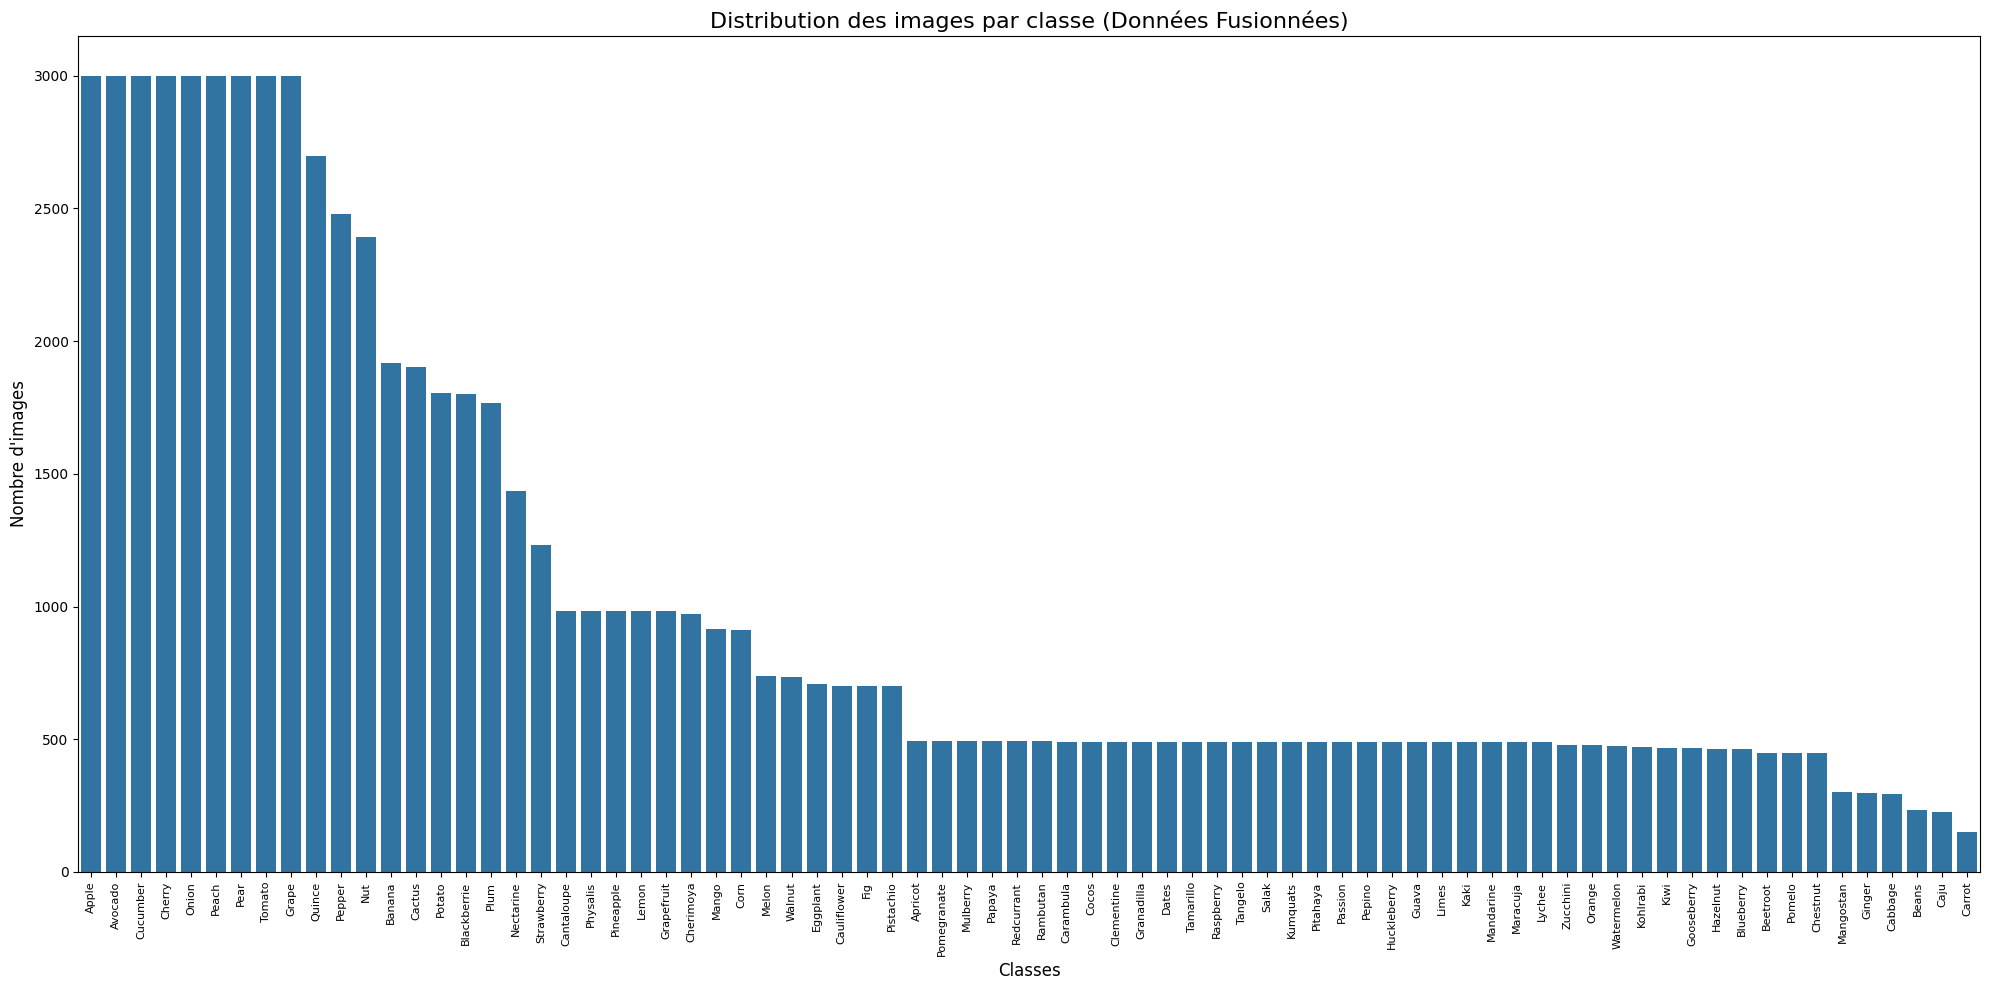

Classes avec le MOINS d'images :
     Classe  Nombre d'images
13   Carrot              151
10     Caju              226
4     Beans              233
8   Cabbage              293
25   Ginger              297

Classes avec le PLUS d'images :
      Classe  Nombre d'images
0      Apple             3000
2    Avocado             3000
21  Cucumber             3000
16    Cherry             3000
48     Onion             3000


In [5]:
# Lister les classes depuis le nouveau dossier
class_names = sorted(os.listdir(train_path_2))
print(f"Nombre total de classes : {len(class_names)}")
print("\nExemple de noms de classes :")
print(class_names[:10]) 

# Compter les images par classe
distribution = {}
for fruit_class in class_names:
    class_dir = os.path.join(train_path_2, fruit_class)
    
    # Compter le nombre de fichiers .jpg ou .png
    if os.path.exists(class_dir):
        count = len([f for f in os.listdir(class_dir)
                     if f.endswith(('.jpg', '.png', '.jpeg'))])
        distribution[fruit_class] = count
    else:
        print(f" {class_dir} n'existe pas.")

# Convertir en DataFrame Pandas pour une analyse plus facile
df_distribution = pd.DataFrame(list(distribution.items()), columns=['Classe', 'Nombre d\'images'])

print(df_distribution)

print("\nStatistiques sur la distribution :")
print(df_distribution['Nombre d\'images'].describe())

#  Visualisation
plt.figure(figsize=(20, 10))

# Trier par ordre décroissant
df_sorted = df_distribution.sort_values(by='Nombre d\'images', ascending=False)

sns.barplot(data=df_sorted, x='Classe', y='Nombre d\'images')

plt.title('Distribution des images par classe (Données Fusionnées)', fontsize=16)
plt.ylabel('Nombre d\'images', fontsize=12)
plt.xlabel('Classes', fontsize=12)

plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

print("Classes avec le MOINS d'images :")
print(df_distribution.sort_values(by='Nombre d\'images', ascending=True).head())

print("\nClasses avec le PLUS d'images :")
print(df_distribution.sort_values(by='Nombre d\'images', ascending=False).head())



La distribution des fruits obtenue après la fusion de leurs variétés présente un déséquilibre marqué dans la répartition des effectifs. Cette forte disparité pourrait impacter la performance de nos futurs modèles.

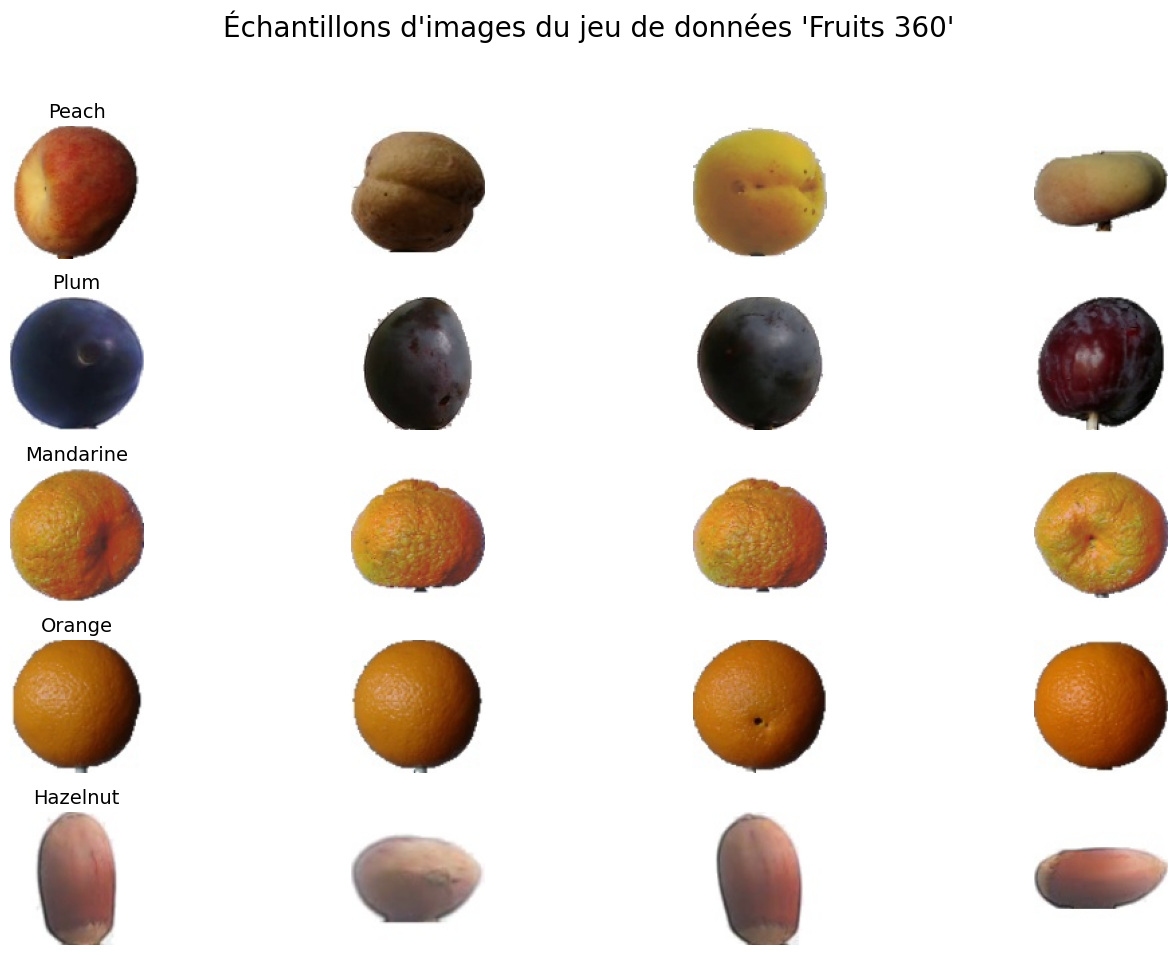

In [ ]:
num_classes_to_show = 5
num_images_per_class = 4

plt.figure(figsize=(15, 10))
# Prendre 5 classes au hasard
random_classes = np.random.choice(class_names, num_classes_to_show, replace=False)

for i, class_name in enumerate(random_classes):
    class_path = os.path.join(train_path_2, class_name)
    # Prendre 4 images au hasard
    all_image_files = os.listdir(class_path)

    if len(all_image_files) >= num_images_per_class:
        image_files = np.random.choice(all_image_files, num_images_per_class, replace=False)
    else:
        image_files = all_image_files
    for j, img_file in enumerate(image_files):
        img_path = os.path.join(class_path, img_file)

        # Lire l'image
        img = Image.open(img_path)

        ax = plt.subplot(num_classes_to_show, num_images_per_class, i * num_images_per_class + j + 1)
        plt.imshow(img)
        plt.axis('off')

        # Titre pour la première image
        if j == 0:
            plt.title(class_name, fontsize=14)

plt.suptitle("Échantillons d'images du jeu de données 'Fruits 360'", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

## Équilibrage du Dataset

Un déséquilibre important a été observé entre les classes. Nous avons donc limité chaque classe à 3000 images, en supprimant aléatoirement les images excédentaires.

Cette approche permet de réduire le biais du modèle en faveur des classes majoritaires, tout en évitant d’avoir recours à une pondération complexe lors de l’entraînement.

Nous aurions également pu utiliser des métriques ou des fonctions de perte pénalisant davantage les erreurs sur les classes minoritaires, afin d’éviter que le modèle ne se contente de prédire majoritairement la classe la plus représentée.

In [ ]:
MAX_IMAGES_PER_CLASS = 3000
target_dir = os.path.join(OUTPUT_DIR, "Training")


classes = sorted(os.listdir(target_dir))
total_deleted = 0
classes_modified = 0

for class_name in tqdm(classes, desc="Équilibrage des classes"):
      class_path = os.path.join(target_dir, class_name)
        
      if not os.path.isdir(class_path):
          continue
            
      # Lister toutes les images
      images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
      count = len(images)
        
      # Si la classe dépasse le seuil
      if count > MAX_IMAGES_PER_CLASS:
          num_to_delete = count - MAX_IMAGES_PER_CLASS
            
        #mélange les images pour une suppression aléatoire
          random.shuffle(images)
            
          images_to_delete = images[:num_to_delete]
            
          for img in images_to_delete:
              file_to_remove = os.path.join(class_path, img)
              os.remove(file_to_remove)
            
          total_deleted += num_to_delete
          classes_modified += 1

print(f"Total images supprimées : {total_deleted}")
print(f"Nombre de classes impactées : {classes_modified}")



Équilibrage des classes:   0%|          | 0/76 [00:00<?, ?it/s]

Équilibrage des classes: 100%|██████████| 76/76 [00:02<00:00, 33.93it/s]

Total images supprimées : 0
Nombre de classes impactées : 0


### Chargement des Données Fusionnées

In [5]:
IMAGE_SIZE = (100,100)
EPOCHS=15

input_shape = IMAGE_SIZE + (3,)
LEARNING_RATE = 0.001

# Chemins vers tes dossiers fusionnés
train_dir = os.path.join(OUTPUT_DIR, "Training")
test_dir = os.path.join(OUTPUT_DIR, "Test")


# Chargement Train + Validation (Split 80/20)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Chargement Test 
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Récupération des noms de classes
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"\nNombre de classes fusionnées : {num_classes}")
print(f"Classes : {class_names}")

# Optimisation pour la performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Normalisation
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds_norm = test_ds.map(lambda x, y: (normalization_layer(x), y)) 

Found 77785 files belonging to 76 classes.
Using 62228 files for training.
Found 77785 files belonging to 76 classes.
Using 15557 files for validation.
Found 39768 files belonging to 76 classes.

Nombre de classes fusionnées : 76
Classes : ['Apple', 'Apricot', 'Avocado', 'Banana', 'Beans', 'Beetroot', 'Blackberrie', 'Blueberry', 'Cabbage', 'Cactus', 'Caju', 'Cantaloupe', 'Carambula', 'Carrot', 'Cauliflower', 'Cherimoya', 'Cherry', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Cucumber', 'Dates', 'Eggplant', 'Fig', 'Ginger', 'Gooseberry', 'Granadilla', 'Grape', 'Grapefruit', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mangostan', 'Maracuja', 'Melon', 'Mulberry', 'Nectarine', 'Nut', 'Onion', 'Orange', 'Papaya', 'Passion', 'Peach', 'Pear', 'Pepino', 'Pepper', 'Physalis', 'Pineapple', 'Pistachio', 'Pitahaya', 'Plum', 'Pomegranate', 'Pomelo', 'Potato', 'Quince', 'Rambutan', 'Raspberry', 'Redcurrant', 'Salak', '

## Entraînement de nos modèles

### Entraînement Baseline CNN

In [ ]:
print("\n Entraînement Baseline CNN (Merged Data) ")

model_base_merged = models.Sequential([
    layers.Input(shape=(100, 100, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_base_merged.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history_base = model_base_merged.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


--- Entraînement Baseline CNN (Merged Data) ---
Epoch 1/15
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 227s 115ms/step - accuracy: 0.8401 - loss: 0.5927 - val_accuracy: 0.9681 - val_loss: 0.0979
Epoch 2/15
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 108s 55ms/step - accuracy: 0.9765 - loss: 0.0774 - val_accuracy: 0.9839 - val_loss: 0.0551
Epoch 3/15
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 190s 98ms/step - accuracy: 0.9845 - loss: 0.0518 - val_accuracy: 0.9861 - val_loss: 0.0456
Epoch 4/15
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 228s 111ms/step - accuracy: 0.9900 - loss: 0.0349 - val_accuracy: 0.9870 - val_loss: 0.0440
Epoch 5/15
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 214s 110ms/step - accuracy: 0.9893 - loss: 0.0370 - val_accuracy: 0.9813 - val_loss: 0.0689
Epoch 6/15
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 208s 107ms/step - accuracy: 0.9921 - loss: 0.0280 - val_accuracy: 0.9760 - val_loss: 0.0802
Epoch 7/15
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 209s 107ms/step - accuracy: 0.9919 - loss: 0.0296 - val_accuracy: 0.9950 - val_loss: 0.0172
Epoch 8/15
1945

In [ ]:
model_base_merged.save('model_base_merged.keras')


Modèle Baseline sauvegardé.


In [ ]:
model_base_merged = keras.models.load_model('model_base_merged.keras')

### Entraînement MobileNetV2

In [ ]:
# Base pré-entraînée (gelée)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(100, 100, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Construction du modèle
inputs = tf.keras.Input(shape=(100, 100, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_mobilenet_merged = tf.keras.Model(inputs, outputs)

#Compilation Phase 1 
model_mobilenet_merged.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entraînement Phase 1
EPOCHS = 10
history_mobilenet = model_mobilenet_merged.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# Dégeler le modèle de base
base_model.trainable = True

#  On ne veut entraîner que les dernières couches
fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# recompilation Phase 2

model_mobilenet_merged.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entraînement Phase 2
FINE_TUNE_EPOCHS = 5
total_epochs = EPOCHS + FINE_TUNE_EPOCHS

history_fine = model_mobilenet_merged.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history_mobilenet.epoch[-1], 
)

C:\Users\aslam\AppData\Local\Temp\ipykernel_17272\794325946.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


--- Démarrage Phase 1 : Feature Extraction ---
Epoch 1/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 234s 117ms/step - accuracy: 0.9150 - loss: 0.3014 - val_accuracy: 0.9817 - val_loss: 0.0586
Epoch 2/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 200s 103ms/step - accuracy: 0.9806 - loss: 0.0629 - val_accuracy: 0.9927 - val_loss: 0.0271
Epoch 3/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 203s 105ms/step - accuracy: 0.9847 - loss: 0.0450 - val_accuracy: 0.9929 - val_loss: 0.0216
Epoch 4/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 149s 77ms/step - accuracy: 0.9877 - loss: 0.0371 - val_accuracy: 0.9954 - val_loss: 0.0159
Epoch 5/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 127s 65ms/step - accuracy: 0.9887 - loss: 0.0330 - val_accuracy: 0.9959 - val_loss: 0.0129
Epoch 6/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 136s 70ms/step - accuracy: 0.9893 - loss: 0.0298 - val_accuracy: 0.9961 - val_loss: 0.0137
Epoch 7/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 139s 71ms/step - accuracy: 0.9905 - loss: 0.0264 - val_accuracy: 0.9962 - val_loss: 0.0118
Epoch 8/10
1945/194

In [ ]:
model_mobilenet_merged.save('model_mobilenet_merged.keras')

Modèle MobileNet Merged sauvegardé.


In [ ]:
model_mobilenet_merged = keras.models.load_model("model_mobilenet_merged.keras")

## Test de nos modèles

In [ ]:
def analyze_model_performance(model, dataset, y_true, class_names, model_name):
    print(f"\n{'='*20} {model_name} {'='*20}")
    
    # Prédictions
    probs = model.predict(dataset, verbose=0)
    y_pred = np.argmax(probs, axis=1)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f" Accuracy : {acc:.4f}")

    #  Classification Report
    print(f"\n Classification Report ({model_name}) ")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # 4. Top 15 Erreurs
    print(f"\n--- Top 15 Erreurs ({model_name}) ---")
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    np.fill_diagonal(df_cm.values, 0) 

    errors = df_cm.unstack().reset_index()
    errors.columns = ['Predicted', 'True', 'Count']
    errors = errors[errors['Count'] > 0]
    errors = errors[['True', 'Predicted', 'Count']]
    
    top_errors = errors.sort_values(by='Count', ascending=False).head(15)
    print(top_errors.to_string(index=False))

In [ ]:
y_true_normal = np.concatenate([y for x, y in test_ds_norm], axis=0)

# Analyse Baseline
analyze_model_performance(model_base_merged, test_ds_norm, y_true_normal, class_names, "BASELINE CNN (Normal)")

# Analyse MobileNet
analyze_model_performance(model_mobilenet_merged, test_ds_norm, y_true_normal, class_names, "MOBILENET V2 (Normal)")

>>> EXTRACTION DES LABELS (Test Normal)...

==================== BASELINE CNN (Normal) ====================
 Accuracy : 0.9632

--- Classification Report (BASELINE CNN (Normal)) ---
              precision    recall  f1-score   support

       Apple       0.95      0.98      0.96      5426
     Apricot       0.86      1.00      0.92       164
     Avocado       0.98      1.00      0.99      1017
      Banana       0.99      0.89      0.94       645
       Beans       1.00      1.00      1.00        77
    Beetroot       0.97      0.65      0.78       150
 Blackberrie       0.96      1.00      0.98       600
   Blueberry       1.00      0.95      0.98       154
     Cabbage       0.75      1.00      0.86        96
      Cactus       0.85      0.94      0.89       634
        Caju       1.00      0.97      0.99        75
  Cantaloupe       1.00      1.00      1.00       328
   Carambula       0.93      0.90      0.91       166
      Carrot       1.00      1.00      1.00        50
 Caulif

In [ ]:
aug_layer = tf.keras.Sequential([
    # factor=0.5 permet une rotation entre -180° et +180°
    tf.keras.layers.RandomRotation(0.5), 
    tf.keras.layers.RandomZoom(0.1)      
])

In [ ]:
test_ds_aug = test_ds_norm.map(lambda x, y: (aug_layer(x, training=True), y))

y_true_aug = np.concatenate([y for x, y in test_ds_aug], axis=0)

# Analyse Baseline 
analyze_model_performance(
    model_base_merged, 
    test_ds_aug, 
    y_true_aug, 
    class_names, 
    "BASELINE CNN (avec test augmentée)"
)

# Analyse Baseline 
analyze_model_performance(
    model_mobilenet_merged, 
    test_ds_aug, 
    y_true_aug, 
    class_names, 
    "MOBILENET V2 (avec test augmentée)"
)


>>> PRÉPARATION DU TEST STRESS (Rotations 360° + Zoom)...
>>> EXTRACTION DES LABELS (Test Stress)...

==================== BASELINE CNN (Stress 360°) ====================
 Accuracy : 0.3494

--- Classification Report (BASELINE CNN (Stress 360°)) ---
              precision    recall  f1-score   support

       Apple       0.39      0.34      0.36      5426
     Apricot       0.14      0.24      0.18       164
     Avocado       0.27      0.37      0.32      1017
      Banana       0.22      0.57      0.32       645
       Beans       0.87      0.17      0.28        77
    Beetroot       0.32      0.13      0.19       150
 Blackberrie       0.62      0.58      0.60       600
   Blueberry       0.72      0.25      0.38       154
     Cabbage       0.08      0.22      0.12        96
      Cactus       0.18      0.21      0.19       634
        Caju       0.07      0.11      0.08        75
  Cantaloupe       0.68      0.35      0.46       328
   Carambula       0.28      0.17      0.21   

Nous remarquons qu'avec les rotations et zoom effectuées sur les images, nos accuracy chutent énormément ( surtout pour le CNN qu'on a fait à la main), montrant que nos modèles ont dû mal à s'adapter à ces nouvelles données qu'ils n'ont jamais rencontrés. Pour palier à ce problème, nous allons réentrainer nos modèles avec des images avec zoom et rotation.

## Entraînement de nos modèles avec Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
])

In [ ]:
print("\nEntraînement des modèles avec Data Augmentation")

#  Nouveau Baseline Augmenté 
model_base_aug = models.Sequential([
    layers.Input(shape=(100, 100, 3)),
    data_augmentation, # Augmentation en entrée
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_base_aug.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Training Baseline Augmentée...")
model_base_aug.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

#  Nouveau MobileNet Augmenté 
# On réutilise la base figée
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs) # Augmentation en entrée
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_mobilenet_aug = tf.keras.Model(inputs, outputs)
model_mobilenet_aug.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Training MobileNet Augmenté...")
model_mobilenet_aug.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)




--- Entraînement des modèles ROBUSTES (Data Augmentation) ---
Training Baseline Augmentée...
Epoch 1/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 107s 55ms/step - accuracy: 0.5807 - loss: 1.4306 - val_accuracy: 0.7651 - val_loss: 0.7610
Epoch 2/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 105s 54ms/step - accuracy: 0.8399 - loss: 0.4913 - val_accuracy: 0.8400 - val_loss: 0.4720
Epoch 3/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 105s 54ms/step - accuracy: 0.8894 - loss: 0.3391 - val_accuracy: 0.8843 - val_loss: 0.3574
Epoch 4/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 105s 54ms/step - accuracy: 0.9111 - loss: 0.2692 - val_accuracy: 0.9104 - val_loss: 0.2905
Epoch 5/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 105s 54ms/step - accuracy: 0.9267 - loss: 0.2265 - val_accuracy: 0.9400 - val_loss: 0.1826
Epoch 6/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 105s 54ms/step - accuracy: 0.9349 - loss: 0.2001 - val_accuracy: 0.9175 - val_loss: 0.2457
Epoch 7/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 105s 54ms/step - accuracy: 0.9408 - loss: 0.1818 - val_accuracy: 0

In [ ]:
model_base_aug.save('model_base_aug.keras')

In [ ]:
model_base_aug = keras.models.load_model("model_base_aug.keras")

In [60]:
model_mobilenet_aug.save('model_mobilenet_aug.keras')

In [ ]:
model_mobilenet_aug = keras.models.load_model("model_mobilenet_aug.keras")

## Test avec Data Augmentation

In [ ]:
y_true_normal = np.concatenate([y for x, y in test_ds_norm], axis=0)

# Analyse Baseline Augmentée
analyze_model_performance(
    model_base_aug, 
    test_ds_norm, 
    y_true_normal, 
    class_names, 
    "BASELINE CNN AUGMENTED (Normal)"
)

# Analyse MobileNet Augmenté
analyze_model_performance(
    model_mobilenet_aug, 
    test_ds_norm, 
    y_true_normal, 
    class_names, 
    "MOBILENET V2 AUGMENTED (Normal)"
)

>>> EXTRACTION DES LABELS (Test Normal)...

==================== BASELINE CNN AUGMENTED (Normal) ====================
 Accuracy : 0.9054

--- Classification Report (BASELINE CNN AUGMENTED (Normal)) ---
              precision    recall  f1-score   support

       Apple       0.94      0.82      0.87      5426
     Apricot       0.98      1.00      0.99       164
     Avocado       0.82      1.00      0.90      1017
      Banana       0.97      0.98      0.97       645
       Beans       1.00      1.00      1.00        77
    Beetroot       0.99      0.59      0.74       150
 Blackberrie       0.87      1.00      0.93       600
   Blueberry       1.00      1.00      1.00       154
     Cabbage       1.00      0.90      0.95        96
      Cactus       0.80      0.97      0.88       634
        Caju       1.00      0.63      0.77        75
  Cantaloupe       1.00      1.00      1.00       328
   Carambula       0.46      0.98      0.63       166
      Carrot       1.00      1.00      1.

In [ ]:
aug_layer = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.5), # Rotation 
    tf.keras.layers.RandomZoom(0.1)      # Zoom 
])

test_ds_aug = test_ds_norm.map(lambda x, y: (aug_layer(x, training=True), y))

y_true_aug = np.concatenate([y for x, y in test_ds_aug], axis=0)

# Analyse Baseline Augmentée
analyze_model_performance(
    model_base_aug, 
    test_ds_aug, 
    y_true_aug, 
    class_names, 
    "BASELINE CNN AUGMENTED (data augmentation)"
)

# Analyse MobileNet Augmenté
analyze_model_performance(
    model_mobilenet_aug, 
    test_ds_aug, 
    y_true_aug, 
    class_names, 
    "MOBILENET V2 AUGMENTED (data augmentation)"
)


>>> PRÉPARATION DU TEST STRESS (Rotations 360° + Zoom)...
>>> EXTRACTION DES LABELS (Test Stress)...

==================== BASELINE CNN AUGMENTED (Stress 360°) ====================
 Accuracy : 0.9240

--- Classification Report (BASELINE CNN AUGMENTED (Stress 360°)) ---
              precision    recall  f1-score   support

       Apple       0.92      0.84      0.88      5426
     Apricot       0.86      0.99      0.92       164
     Avocado       0.94      1.00      0.97      1017
      Banana       0.92      0.98      0.95       645
       Beans       1.00      1.00      1.00        77
    Beetroot       0.85      0.61      0.71       150
 Blackberrie       0.99      1.00      0.99       600
   Blueberry       1.00      1.00      1.00       154
     Cabbage       1.00      0.97      0.98        96
      Cactus       0.81      1.00      0.89       634
        Caju       0.96      0.87      0.91        75
  Cantaloupe       0.90      1.00      0.95       328
   Carambula       0.64   

On remarque que cela aide énormément nos modèles à faire face à ces nouvelles données, car les accuracy ré-augmentent grandement, revenant presque aux accuracy des modèles précédent. 

Nous allons maintenant faire une recherche d'hyper-paramètre pour notre modèle CNN en essayant de maximiser l'accuracy.

## Recherche d'hyper-paramètres

In [ ]:
def objective(trial):
    tf.keras.backend.clear_session() # pour libérer la RAM entre les essais

    # Hyperparamètres à optimiser
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5)

    # Rebatch dynamique
    train_opt = train_ds.unbatch().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_opt = val_ds.unbatch().batch(batch_size).prefetch(tf.data.AUTOTUNE)

    model = models.Sequential([
            layers.Input(shape=(100, 100, 3)),
            data_augmentation,
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D(2),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D(2),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(num_classes, activation='softmax')
        ])

    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Training 
    history = model.fit(
        train_opt,
        validation_data=val_opt,
        epochs=5,
        verbose=0
    )

    # Score Optuna
    return history.history["val_accuracy"][-1]

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15, show_progress_bar=True)

print(f"Meilleurs paramètres : {study.best_params}")
print(f"Meilleure val_accuracy : {study.best_value:.2%}")

BEST_LR = study.best_params["learning_rate"]
BEST_BS = study.best_params["batch_size"]
BEST_DROPOUT = study.best_params["dropout"]

[I 2025-11-30 09:34:54,911] A new study created in memory with name: no-name-7008f9bd-763e-41fb-89ec-da8d46a626a6


Optimisation du modèle : CNN



  0%|          | 0/15 [00:00<?, ?it/s]c:\Users\aslam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
Best trial: 0. Best value: 0.937777:   7%|▋         | 1/15 [17:07<3:59:50, 1027.87s/it]

[I 2025-11-30 09:52:02,768] Trial 0 finished with value: 0.9377772212028503 and parameters: {'learning_rate': 0.0001625877062171717, 'batch_size': 16, 'dropout': 0.4254851997858945}. Best is trial 0 with value: 0.9377772212028503.


Best trial: 1. Best value: 0.939256:  13%|█▎        | 2/15 [33:26<3:36:26, 998.95s/it] 

[I 2025-11-30 10:08:21,487] Trial 1 finished with value: 0.9392556548118591 and parameters: {'learning_rate': 0.0009487818286568987, 'batch_size': 16, 'dropout': 0.4218900316437162}. Best is trial 1 with value: 0.9392556548118591.


Best trial: 2. Best value: 0.954811:  20%|██        | 3/15 [47:04<3:03:14, 916.20s/it]

[I 2025-11-30 10:21:59,210] Trial 2 finished with value: 0.9548113346099854 and parameters: {'learning_rate': 0.0005148982992746546, 'batch_size': 32, 'dropout': 0.1326010387328164}. Best is trial 2 with value: 0.9548113346099854.


Best trial: 2. Best value: 0.954811:  27%|██▋       | 4/15 [59:15<2:34:36, 843.30s/it]

[I 2025-11-30 10:34:10,767] Trial 3 finished with value: 0.035868097096681595 and parameters: {'learning_rate': 0.008953331868205894, 'batch_size': 64, 'dropout': 0.49826896560419}. Best is trial 2 with value: 0.9548113346099854.


Best trial: 2. Best value: 0.954811:  33%|███▎      | 5/15 [1:12:56<2:19:10, 835.04s/it]

[I 2025-11-30 10:47:51,134] Trial 4 finished with value: 0.9373915195465088 and parameters: {'learning_rate': 0.0009553865356613664, 'batch_size': 32, 'dropout': 0.4949154724303402}. Best is trial 2 with value: 0.9548113346099854.


Best trial: 2. Best value: 0.954811:  40%|████      | 6/15 [1:26:27<2:04:03, 827.10s/it]

[I 2025-11-30 11:01:22,845] Trial 5 finished with value: 0.8531850576400757 and parameters: {'learning_rate': 0.0028221010159407895, 'batch_size': 32, 'dropout': 0.11257756858028474}. Best is trial 2 with value: 0.9548113346099854.


Best trial: 2. Best value: 0.954811:  47%|████▋     | 7/15 [1:42:40<1:56:38, 874.76s/it]

[I 2025-11-30 11:17:35,725] Trial 6 finished with value: 0.035868097096681595 and parameters: {'learning_rate': 0.007088418518572489, 'batch_size': 16, 'dropout': 0.2261694078809002}. Best is trial 2 with value: 0.9548113346099854.


Best trial: 7. Best value: 0.956418:  53%|█████▎    | 8/15 [1:56:25<1:40:12, 858.93s/it]

[I 2025-11-30 11:31:20,754] Trial 7 finished with value: 0.9564183354377747 and parameters: {'learning_rate': 0.00028047259964990735, 'batch_size': 32, 'dropout': 0.4121585608674929}. Best is trial 7 with value: 0.9564183354377747.


Best trial: 7. Best value: 0.956418:  60%|██████    | 9/15 [2:08:45<1:22:09, 821.65s/it]

[I 2025-11-30 11:43:40,417] Trial 8 finished with value: 0.9389985203742981 and parameters: {'learning_rate': 0.0021433679551501536, 'batch_size': 64, 'dropout': 0.15357018576555725}. Best is trial 7 with value: 0.9564183354377747.


Best trial: 7. Best value: 0.956418:  67%|██████▋   | 10/15 [2:21:15<1:06:37, 799.52s/it]

[I 2025-11-30 11:56:10,377] Trial 9 finished with value: 0.8432859778404236 and parameters: {'learning_rate': 0.00011886288370162455, 'batch_size': 64, 'dropout': 0.4973852531945203}. Best is trial 7 with value: 0.9564183354377747.


Best trial: 7. Best value: 0.956418:  73%|███████▎  | 11/15 [2:35:05<53:55, 808.79s/it]  

[I 2025-11-30 12:10:00,204] Trial 10 finished with value: 0.9426624774932861 and parameters: {'learning_rate': 0.0003104879759366968, 'batch_size': 32, 'dropout': 0.3315347496806579}. Best is trial 7 with value: 0.9564183354377747.


Best trial: 11. Best value: 0.970881:  80%|████████  | 12/15 [2:50:01<41:46, 835.48s/it]

[I 2025-11-30 12:24:56,716] Trial 11 finished with value: 0.9708812832832336 and parameters: {'learning_rate': 0.0003539511248268404, 'batch_size': 32, 'dropout': 0.2925016974831035}. Best is trial 11 with value: 0.9708812832832336.


Best trial: 11. Best value: 0.970881:  87%|████████▋ | 13/15 [3:07:41<30:06, 903.39s/it]

[I 2025-11-30 12:42:36,363] Trial 12 finished with value: 0.932763397693634 and parameters: {'learning_rate': 0.00029434761284753344, 'batch_size': 32, 'dropout': 0.30938365682052005}. Best is trial 11 with value: 0.9708812832832336.


Best trial: 13. Best value: 0.971974:  93%|█████████▎| 14/15 [3:22:55<15:06, 906.54s/it]

[I 2025-11-30 12:57:50,184] Trial 13 finished with value: 0.9719740152359009 and parameters: {'learning_rate': 0.0003686045855265012, 'batch_size': 32, 'dropout': 0.24828060105718516}. Best is trial 13 with value: 0.9719740152359009.


Best trial: 13. Best value: 0.971974: 100%|██████████| 15/15 [3:38:34<00:00, 874.30s/it]

[I 2025-11-30 13:13:29,383] Trial 14 finished with value: 0.9533971548080444 and parameters: {'learning_rate': 0.0005339730108144742, 'batch_size': 32, 'dropout': 0.23120515353403132}. Best is trial 13 with value: 0.9719740152359009.
Meilleurs paramètres : {'learning_rate': 0.0003686045855265012, 'batch_size': 32, 'dropout': 0.24828060105718516}
Meilleure val_accuracy : 97.20%


Maintenant, nous recompilons et fitons le nouveau modèle avec les meilleurs hyper-paramètres obtenus avec notre étude Optuna.

In [ ]:
best_params = study.best_params
BEST_LR = best_params["learning_rate"]
BEST_BS = best_params["batch_size"]
BEST_DROPOUT = best_params["dropout"]

print(f" Paramètres retenus : LR={BEST_LR:.5f}, Batch={BEST_BS}, Dropout={BEST_DROPOUT:.2f}")

train_final = train_ds.unbatch().batch(BEST_BS).cache().prefetch(tf.data.AUTOTUNE)
val_final = val_ds.unbatch().batch(BEST_BS).cache().prefetch(tf.data.AUTOTUNE)

model_best_cnn = models.Sequential([
    layers.Input(shape=(100, 100, 3)),
    
    data_augmentation, 
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    
    layers.Dropout(BEST_DROPOUT),
    
    layers.Dense(num_classes, activation='softmax')
])

model_best_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=BEST_LR),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_final = model_best_cnn.fit(
    train_final,
    validation_data=val_final,
    epochs=15, 
    verbose=1
)

# Sauvegarde du modèle
model_name = "best_cnn_optuna.keras"
model_best_cnn.save(model_name)


 Paramètres retenus : LR=0.00037, Batch=32, Dropout=0.25
Epoch 1/15
   1945/Unknown 173s 87ms/step - accuracy: 0.3452 - loss: 2.4418

c:\Users\aslam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1945/1945 ━━━━━━━━━━━━━━━━━━━━ 184s 93ms/step - accuracy: 0.5268 - loss: 1.6228 - val_accuracy: 0.8541 - val_loss: 0.4754
Epoch 2/15
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 189s 97ms/step - accuracy: 0.8131 - loss: 0.5663 - val_accuracy: 0.9087 - val_loss: 0.2989
Epoch 3/15
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 170s 87ms/step - accuracy: 0.8727 - loss: 0.3763 - val_accuracy: 0.9243 - val_loss: 0.2283
Epoch 4/15
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 200s 103ms/step - accuracy: 0.9025 - loss: 0.2880 - val_accuracy: 0.9410 - val_loss: 0.1854
Epoch 5/15
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 288s 148ms/step - accuracy: 0.9191 - loss: 0.2408 - val_accuracy: 0.9620 - val_loss: 0.1150
Epoch 6/15
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 213s 109ms/step - accuracy: 0.9311 - loss: 0.2020 - val_accuracy: 0.9233 - val_loss: 0.2685
Epoch 7/15
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 181s 93ms/step - accuracy: 0.9381 - loss: 0.1783 - val_accuracy: 0.9713 - val_loss: 0.0862
Epoch 8/15
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 172s 88ms/step - accuracy: 0.9457 -

In [ ]:
model_best_cnn = tf.keras.models.load_model("best_cnn_optuna.keras")

In [ ]:
y_true_normal = np.concatenate([y for x, y in test_ds_norm], axis=0)

analyze_model_performance(
    model_best_cnn, 
    test_ds_norm, 
    y_true_normal, 
    class_names, 
    "BEST CNN OPTUNA (Normal)"
)

test_ds_aug = test_ds_norm.map(lambda x, y: (aug_layer(x, training=True), y))

y_true_aug = np.concatenate([y for x, y in test_ds_aug], axis=0)

analyze_model_performance(
    model_best_cnn, 
    test_ds_aug, 
    y_true_aug, 
    class_names, 
    "BEST CNN OPTUNA (avec Data Augmentation)"
)


==================== BEST CNN OPTUNA (Normal) ====================
 Accuracy : 0.9604

 Classification Report (BEST CNN OPTUNA (Normal)) 
              precision    recall  f1-score   support

       Apple       0.97      0.91      0.94      5426
     Apricot       1.00      1.00      1.00       164
     Avocado       0.97      1.00      0.98      1017
      Banana       0.97      0.96      0.97       645
       Beans       1.00      1.00      1.00        77
    Beetroot       1.00      0.39      0.56       150
 Blackberrie       0.97      1.00      0.99       600
   Blueberry       0.99      1.00      1.00       154
     Cabbage       1.00      1.00      1.00        96
      Cactus       0.88      0.99      0.93       634
        Caju       1.00      0.92      0.96        75
  Cantaloupe       1.00      1.00      1.00       328
   Carambula       0.61      1.00      0.75       166
      Carrot       1.00      1.00      1.00        50
 Cauliflower       0.90      1.00      0.95       

## Analyse des Résultats

### Synthèse des Performances

| Modèle | Test Normal | Test Perturbé |
| :--- | :---: | :---: |
| **Baseline CNN (Simple)** | 96.32% | 34.94% |
| **MobileNetV2 (Simple)** | 98.39% | 61.82% |
| **Baseline CNN (Augmenté)** | 90.54% | 92.40% |
| **Best CNN (Optuna Augmenté)** | 96.04% | 96.38% |
| **MobileNetV2 (Augmenté)** | 96.45% | 97.70% |


**Effondrement sans Data Augmentation**
Les modèles standards apprennent par cœur des positions fixes. Dès que l'image tourne, la Baseline devient inopérante (35%). MobileNet résiste mieux (62%) grâce à sa base de connaissances, mais reste insuffisant pour la production.

**Apport de la Data Augmentation**
L'augmentation force le modèle à généraliser. On perd légèrement en précision sur les données parfaites, mais on gagne massivement en stabilité sur les données réelles et modifiées.

**Performance d'Optuna**
Le CNN optimisé par Optuna est une excellente alternative : avec 96% de réussite dans les deux tests, il prouve qu'une architecture simple mais bien réglée peut rivaliser avec des modèles complexes.

**Meilleur Modèle**
Le MobileNetV2 Augmenté reste le plus performant (97.70%). Il combine efficacement la richesse des caractéristiques visuelles pré-apprises et l'invariance aux rotations.

## RAG



Pour cette dernière partie, nous mettons en œuvre une architecture RAG. L'objectif est de dépasser la classification simple en introduisant un système capable de "raisonner" sur le contexte.

Notre pipeline se déroule en trois étapes :

1.  **Vectorisation (CLIP)** : Transformation des images en vecteurs sémantiques denses via `openai/clip-vit-base-patch32`.
2.  **Recherche (FAISS)** : Pour chaque image test, récupération instantanée des **$k=10$ voisins** les plus similaires dans la base d'entraînement.
3.  **Décision (LLM Local)** : Les métadonnées des voisins (classe et score) sont fournies à un LLM (**Qwen2.5-0.5B-Instruct**) qui agit comme juge pour déterminer la classe finale et justifier son choix.

In [6]:
from collections import defaultdict
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "openai/clip-vit-base-patch32" 
train_dir = train_path_2  
test_dir = test_path_2    

output_dir = "data_embedded"
os.makedirs(output_dir, exist_ok=True)

embeddings_path = os.path.join(output_dir, "clip_embeddings.npy")
metadata_path = os.path.join(output_dir, "clip_metadata.json")
index_path = os.path.join(output_dir, "clip_index.faiss")


# Charger CLIP (processor + model)
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name).to(device)
model.eval()


# Fonctions d'encodage
# Encode une Image, renvoie vecteur L2-normalized.
def encode_image_to_embedding(pil_image):

    inputs = processor(images=pil_image, return_tensors="pt").to(device)
    with torch.no_grad():
        emb = model.get_image_features(**inputs)  # (1, dim)
    emb = emb.cpu().numpy().astype('float32')
    # normalisation L2
    faiss.normalize_L2(emb)
    return emb.reshape(-1)

def get_clip_image_embedding_from_path(img_path):
    img = Image.open(img_path).convert("RGB")
    return encode_image_to_embedding(img)


# Pour directement charger index + metadata sauvegardés
def load_index_and_metadata(load_dir=output_dir):
    idx_path = os.path.join(load_dir, "fruits-grouped\clip_index.faiss")
    meta_path = os.path.join(load_dir, "clip_metadata.json")
    if not os.path.exists(idx_path) or not os.path.exists(meta_path):
        raise FileNotFoundError("Index ou metadata absent.")
    index = faiss.read_index(idx_path)
    with open(meta_path, "r") as f:
        metadatas = json.load(f)
    for idx, meta in enumerate(metadatas):
        if "id" not in meta:
            meta["id"] = idx
    return index, metadatas


# Recherche / KNN
def search_image_query(img_path, index, metadatas, k=5):
    q = get_clip_image_embedding_from_path(img_path).astype('float32').reshape(1, -1)
    D, I = index.search(q, k)  # D: similarity scores, I: ids
    results = []
    for score, idx in zip(D[0], I[0]):
        # trouver meta par id (ici metadatas list contient 'id')
        # créons un mapping id->meta
        results.append({"score": float(score), "id": int(idx)})
    # map ids to metadata
    id_to_meta = {int(m["id"]): m for m in metadatas}
    enriched = []
    for r in results:
        meta = id_to_meta.get(r["id"], {"path": None, "class": None, "filename": None})
        enriched.append({**r, **meta})
    return enriched

# Retourne la liste de classes prédites ( weighted voting)
def predict_knn_weighted_batch(embeddings_query, index, metadatas, k=10):
    if embeddings_query.ndim == 1:
        embeddings_query = embeddings_query.reshape(1, -1)

    D, I = index.search(embeddings_query.astype('float32'), k)
    id_to_meta = {int(m["id"]): m for m in metadatas}

    preds = []
    for scores, ids in zip(D, I):
        # scores are cos similarities
        class_scores = defaultdict(float)
        for score, id_ in zip(scores, ids):
            meta = id_to_meta.get(int(id_), None)
            if not meta:
                continue
            class_scores[meta['class']] += float(score)

        if class_scores:
            # on choisit la classe avec le maximum du score cumulatif
            pred = max(class_scores.items(), key=lambda x: x[1])[0]
        else:
            pred = None
        preds.append(pred)
    return preds


def ask_local_llm(context_text, llm_pipe):
    messages = [
        {"role": "system", "content": "Tu es un assistant expert en classification de fruits, précis et concis. Réponds uniquement au format JSON."},
        {"role": "user", "content": f"""
        Voici une liste d'images similaires trouvées (Classe | Score) :
        {context_text}

        Quelle est la classe la plus probable ?
        Réponds avec ce JSON exact : {{"predicted_class": "...", "confidence": "...", "reasoning": "..."}}
        """}
    ]

    outputs = llm_pipe(
        messages,
        max_new_tokens=128,
        temperature=0.1,
        do_sample=False,
        return_full_text=False # Pour obtenir uniquement la réponse
    )
    
    generated_text = outputs[0]["generated_text"]
    
    try:
        start = generated_text.find('{')
        end = generated_text.rfind('}') + 1
        if start != -1 and end != -1:
            return json.loads(generated_text[start:end])
        else:
            return {"raw_output": generated_text, "predicted_class": "Erreur format", "reasoning": "Output non JSON parsable"}
    except Exception as e:
        return {"error": f"Parsing JSON failed: {e}", "raw": generated_text, "predicted_class": None}

def load_llm_pipeline():
 
    print("Chargement de Qwen")
    pipe = pipeline(
            "text-generation",
            model="Qwen/Qwen2.5-0.5B-Instruct",
            model_kwargs={"torch_dtype": "auto", "device_map": "auto"}
        )
    return pipe


def llm_decide_local_transformers(query_path, neighbors):
    llm_pipe = load_llm_pipeline()
    
    context_lines = []
    for r in neighbors:
        context_lines.append(f"- {r.get('class')} (Score: {r.get('score'):.4f})")
    context_text = "\n".join(context_lines)
    
    llm_output = ask_local_llm(context_text, llm_pipe)
    
    # Récupérer uniquement la prédiction
    return llm_output.get("predicted_class")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# Configuration des chemins
output_dir = "data_embedded"
os.makedirs(output_dir, exist_ok=True)

out_embeddings_path = os.path.join(output_dir, "clip_embeddings.npy")
metadata_path = os.path.join(output_dir, "clip_metadata.json")

dataset_dir = train_path_2

embeddings = []
metadatas = []

# Extraction
if os.path.exists(dataset_dir):
    for class_name in sorted(os.listdir(dataset_dir)):
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_dir): 
            continue
            
        for fname in tqdm(os.listdir(class_dir), desc=f"Class {class_name}"):
            if not fname.lower().endswith(('.jpg', '.png', '.jpeg')): 
                continue
                
            p = os.path.join(class_dir, fname)
            try:
                emb = encode_image_to_embedding(p)
                embeddings.append(emb)
                metadatas.append({"path": p, "class": class_name, "filename": fname})
            except Exception as e:
                pass

    # Sauvegarde
    if embeddings:
        embeddings = np.vstack(embeddings).astype('float32')
        np.save(out_embeddings_path, embeddings)
        
        with open(metadata_path, "w") as f:
            json.dump(metadatas, f)
            
        print(f"Sauvegarde terminée : {embeddings.shape[0]} vecteurs dans '{output_dir}'")
    else:
        print("Aucun embedding généré.")
else:
    print(f"Erreur : Le dossier source {dataset_dir} n'existe pas.")

Class Zucchini: 100%|██████████| 480/480 [00:35<00:00, 13.50it/s]


Sauvegarde terminée : 77785 vecteurs dans 'data_embedded'


In [15]:
index, metadatas = load_index_and_metadata()

all_test_images = []
for root, dirs, files in os.walk(test_dir):
    for f in files:
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_test_images.append(os.path.join(root, f))
if not all_test_images:
    raise RuntimeError("Aucune image de test trouvée.")

query_img = random.choice(all_test_images)
neighbors = search_image_query(query_img, index, metadatas, k=10)
print("Top neighbors (score, class, filename):")
for n in neighbors:
    print(f"{n['score']:.4f}\t{n['class']}\t{n['filename']}")

# KNN pondéré
q_emb = get_clip_image_embedding_from_path(query_img).astype('float32')
knn_pred = predict_knn_weighted_batch(q_emb, index, metadatas, k=10)[0]
print("KNN weighted prediction:", knn_pred)

# LLM decision (RAG) : construire prompt et appeler LLM 

llm_out = llm_decide_local_transformers(query_img, neighbors)
print("LLM output:\n", llm_out)

Top neighbors (score, class, filename):
0.9975	Redcurrant	Redcurrant 1_222_100.jpg
0.9963	Redcurrant	Redcurrant 1_225_100.jpg
0.9962	Redcurrant	Redcurrant 1_231_100.jpg
0.9957	Redcurrant	Redcurrant 1_220_100.jpg
0.9956	Redcurrant	Redcurrant 1_218_100.jpg
0.9955	Redcurrant	Redcurrant 1_226_100.jpg
0.9954	Redcurrant	Redcurrant 1_219_100.jpg
0.9946	Redcurrant	Redcurrant 1_221_100.jpg
0.9938	Redcurrant	Redcurrant 1_215_100.jpg
0.9937	Redcurrant	Redcurrant 1_102_100.jpg
KNN weighted prediction: Redcurrant
LLM output:
 Redcurrant


In [16]:
# Boucle d'évaluation sur tout le dataset test
def evaluate_on_test_set(test_dataset_images, index, metadatas, k=10, use_llm=False, llm_backend="openai"):
    y_true, y_knn, y_llm = [], [], []
    id_to_meta = {int(m["id"]): m for m in metadatas}

    for p in tqdm(test_dataset_images, desc="Eval test set"):
        true_class = os.path.basename(os.path.dirname(p))
        y_true.append(true_class)

        emb = get_clip_image_embedding_from_path(p).astype('float32')
        knn_pred = predict_knn_weighted_batch(emb, index, metadatas, k=k)[0]
        y_knn.append(knn_pred)

        if use_llm:
            neighbors = search_image_query(p, index, metadatas, k=k)

            cls = llm_decide_local_transformers(p, neighbors) 
            y_llm.append(cls)


    return y_true, y_knn, y_llm

MAX_TEST_SAMPLES = 1000
random.shuffle(all_test_images)
all_test_images = all_test_images[:MAX_TEST_SAMPLES]

y_true, y_knn, y_llm = evaluate_on_test_set(all_test_images, index, metadatas, k=10, use_llm=True, llm_backend="openai")

Eval test set:   0%|          | 0/1000 [00:00<?, ?it/s]

Eval test set: 100%|██████████| 1000/1000 [1:32:26<00:00,  5.55s/it]


In [ ]:
y_llm_clean = [str(pred) if pred is not None else "Unknown" for pred in y_llm]
y_knn_clean = [str(pred) if pred is not None else "Unknown" for pred in y_knn]

acc_knn = accuracy_score(y_true, y_knn_clean)
acc_llm = accuracy_score(y_true, y_llm_clean)

print(f"RÉSULTATS GLOBAUX ({len(y_true)} images)")
print(f"Accuracy KNN seul : {acc_knn:.2%}")
print(f"Accuracy KNN + LLM : {acc_llm:.2%}")
print("-" * 30)

print("\n Classification Report: KNN ")
print(classification_report(y_true, y_knn_clean, digits=3))

print("\n Classification Report: LLM Reranking ")
print(classification_report(y_true, y_llm_clean, digits=3, zero_division=0)) 

unique_labels = sorted(list(set(y_true)))



RÉSULTATS GLOBAUX (1000 images)
Accuracy KNN seul : 98.60%
Accuracy KNN + LLM : 98.70%
------------------------------

--- Classification Report: KNN ---
              precision    recall  f1-score   support

       Apple      0.991     0.982     0.986       111
     Apricot      1.000     1.000     1.000        10
     Avocado      1.000     1.000     1.000        34
      Banana      1.000     1.000     1.000        18
       Beans      1.000     1.000     1.000         1
    Beetroot      1.000     0.600     0.750         5
 Blackberrie      1.000     1.000     1.000        11
   Blueberry      0.833     1.000     0.909         5
      Cactus      1.000     1.000     1.000        14
  Cantaloupe      1.000     1.000     1.000        11
   Carambula      1.000     1.000     1.000         4
      Carrot      1.000     1.000     1.000         2
 Cauliflower      1.000     1.000     1.000         5
   Cherimoya      1.000     1.000     1.000         7
      Cherry      0.987     1.000  

### Conclusion et Analyse

L'évaluation a été réalisée sur un échantillon représentatif de **1000 images** du jeu de test, le coût computationnel de l'inférence LLM empêchant un traitement complet dans le temps imparti.

**Résultats Clés :**
* **Performance CLIP (KNN) : 98.60%**. Les embeddings de CLIP sont extrêmement robustes, rendant la classification triviale pour la majorité des fruits.
* **Apport du LLM (RAG) : 98.70%**. Le gain est marginal (+0.10%), mais le LLM corrige des erreurs sur les classes difficiles (ex: le rappel de `Beetroot` passe de 0.60 à 0.80).

L'approche RAG démontre que la combinaison **CLIP + FAISS** constitue déjà un état de l'art solide. Si le LLM n'apporte pas un gain massif de précision globale, il offre une capacité d'**explicabilité** et de correction sur les cas limites.

**Perspective :**
Il serait pertinent d'étendre l'évaluation à l'intégralité du dataset pour comparer rigoureusement ce pipeline face aux CNN classiques (ResNet, VGG) entraînés précédemment, ce que nous n'avons pas pu faire ici par contrainte de temps.

Nous pourrions également changer notre stratégie pour une application réelle : utiliser la méthodologie avec le LLM pour d'abord séparer les types de fruits (classification générale), puis utiliser ensuite un classifier "spécialisé" (comme nos CNN ou MobileNetV2 entraînés précédemment) pour distinguer précisément les variétés de ces mêmes fruits.